In [22]:
import os
from dotenv import load_dotenv
from image_helper import ImageHelper
from datetime import datetime
from plantcv import plantcv as pcv
import matplotlib
import numpy as np
import image_helper

load_dotenv()

base_url = os.environ.get("STORAGE_URL")
assert base_url
im_helper = ImageHelper(base_url)


# Set debug to the global parameter 
pcv.params.debug = None


In [23]:
def load_images(dt_str):
    dt = im_helper.dt_from_string(dt_str)
    assert(im_helper.get(dt, "side"))
    side_img, path, filename = pcv.readimage(im_helper.image.name)
    side_crop_img = pcv.crop(img=side_img, x=300, y=470, h=1100, w=2800)
    assert(im_helper.get(dt, "top"))
    top_img, path, filename = pcv.readimage(im_helper.image.name)
    top_crop_img = pcv.crop(img=top_img, x=730, y=480, h=1430, w=1980)
    return side_crop_img, top_crop_img

def filter_top_image(crop_img):
    corrected_img = pcv.white_balance(img=crop_img, mode='hist', roi=[280, 120, 5, 5])
    rotate_img = pcv.transform.rotate(corrected_img, 2, True)
    gray_img = pcv.rgb2gray_lab(rgb_img=rotate_img, channel='b')
    return gray_img

def filter_side_image(crop_img):
    rotate_img = pcv.transform.rotate(crop_img, -1, True)
    gray_img = pcv.rgb2gray_lab(rgb_img=rotate_img, channel='l')
    return gray_img

def create_top_mask(gray_img):
    thresh = pcv.threshold.binary(gray_img=gray_img, threshold=55, max_value=255, object_type='dark')
    rois, roi_hierarchy = pcv.roi.multi(img=gray_img, coord=(550,460), radius=180, 
                                    spacing=(550, 580), nrows=2, ncols=3)
    roi_mask = pcv.roi.roi2mask(img=gray_img, contour=rois[0])
    for r in rois:
        new_mask = pcv.roi.roi2mask(img=gray_img, contour=r)
        roi_mask = np.maximum(roi_mask, new_mask)
    combined_mask = np.minimum(roi_mask, thresh)
    filled_mask = pcv.fill(bin_img=combined_mask, size=200)
    pcv.plot_image(filled_mask)
    return filled_mask, rois, roi_hierarchy

def create_side_mask(gray_img):
    thresh = pcv.threshold.binary(gray_img=gray_img, threshold=80, max_value=255, object_type='light')
    rect_contour1, rect_hierarchy1 = pcv.roi.rectangle(img=gray_img, x=400, y=300, h=800, w=550)
    rect_contour2, rect_hierarchy2 = pcv.roi.rectangle(img=gray_img, x=1000, y=300, h=800, w=550)
    rect_contour3, rect_hierarchy3 = pcv.roi.rectangle(img=gray_img, x=1850, y=400, h=700, w=550)
    rois = [rect_contour1, rect_contour2, rect_contour3]
    roi_hierarchy = [rect_hierarchy1, rect_hierarchy2, rect_hierarchy3]
    roi_mask = pcv.roi.roi2mask(img=gray_img, contour=rois[0])
    for r in rois:
        new_mask = pcv.roi.roi2mask(img=gray_img, contour=r)
        roi_mask = np.maximum(roi_mask, new_mask)
    combined_mask = np.minimum(roi_mask, thresh)
    filled_mask = pcv.fill_holes(bin_img=combined_mask)
    filled_mask = pcv.fill(bin_img=combined_mask, size=200)
    pcv.plot_image(filled_mask)
    return filled_mask, rois, roi_hierarchy

def analyze_shape(rois, roi_hierarchy, crop_img, mask):
    obj, obj_hierarchy = pcv.find_objects(img=crop_img, mask=mask)
    plant_ids = range(0, len(rois))
    img_copy = np.copy(crop_img)
    pixel_heights = []
    pixel_areas = []
    # Create a for loop to interate through every ROI (plant) in the image
    for i in range(0, len(rois)):
        roi = rois[i]
        hierarchy = roi_hierarchy[i]
        plant_id = plant_ids[i]
        # Subset objects that overlap the ROI
        plant_contours, plant_hierarchy, mask, area = pcv.roi_objects(img=crop_img, 
                                                                    roi_contour=roi, 
                                                                    roi_hierarchy=hierarchy, 
                                                                    object_contour=obj, 
                                                                    obj_hierarchy=obj_hierarchy, 
                                                                    roi_type="partial")

        # If the plant area is zero then no plant was detected for the ROI
        # and no measurements can be done
        if area > 0:
            # Combine contours together for each plant
            plant_obj, plant_mask = pcv.object_composition(img=crop_img, 
                                                        contours=plant_contours, 
                                                        hierarchy=plant_hierarchy)        
            # Analyze the shape of each plant
            img_copy = pcv.analyze_object(img=img_copy, obj=plant_obj, 
                                        mask=plant_mask, label=f"plant{plant_id}")
            pixel_heights.append(pcv.outputs.observations[f"plant{plant_ids[i]}"]['height']['value'])
            pixel_areas.append(pcv.outputs.observations[f"plant{plant_ids[i]}"]['area']['value'])
    pcv.plot_image(img_copy)
    return pixel_heights, pixel_areas

def expand_pixel_heights(pixel_heights):
    """
    Pretend pixel heights are captured for all plants
    """
    pixel_heights_adjusted = []
    for p in pixel_heights:
        pixel_heights_adjusted.append(p)
        pixel_heights_adjusted.append(p)
    return pixel_heights_adjusted

def reorder_areas_to_match_heights(pixel_areas):
    areas = []
    areas.append(pixel_areas[0])
    areas.append(pixel_areas[3])
    areas.append(pixel_areas[1])
    areas.append(pixel_areas[4])
    areas.append(pixel_areas[2])
    areas.append(pixel_areas[5])
    return areas

def calculate_plant_size(pixel_heights, pixel_areas):
    """
    Calculate the real world size of the plants
    """
    #constants
    hor_dist_front_plant = 125 #mm
    hor_dist_back_plant = 165 #mm
    dist_to_soil = 200 #mm
    K = np.matrix([[2719, 0.000000, 3280/2], 
                    [0.000000, 2719, 2464/2], 
                    [0.000000, 0.000000, 1.000000]])

    plant_height = []
    plant_area = []
    
    for i in range(0, len(pixel_heights)):
        
        #calculate plant height
        if i % 2 == 0:
            plant_height.append(hor_dist_back_plant / 2719 * pixel_heights[i])
        else:
            plant_height.append(hor_dist_front_plant / 2719 * pixel_heights[i])

        #calculate plant area
        vert_dist_to_plant = dist_to_soil - plant_height[i]
        plant_area.append(vert_dist_to_plant ** 2 / 2719 ** 2 * pixel_areas[i])
    
    return plant_height, plant_area
    


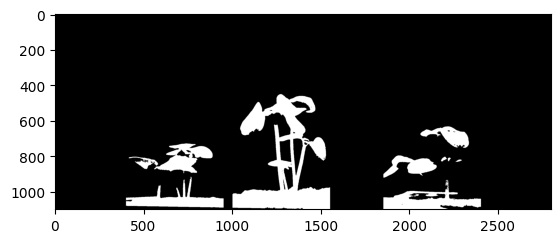

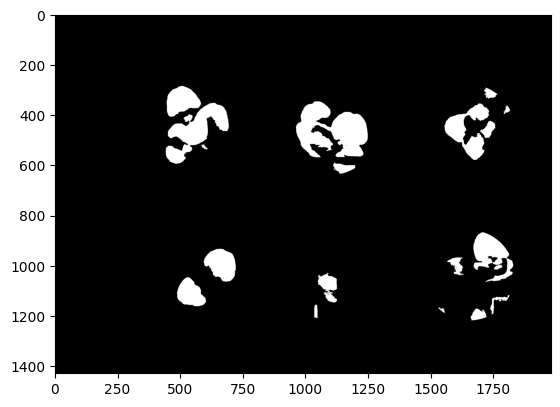

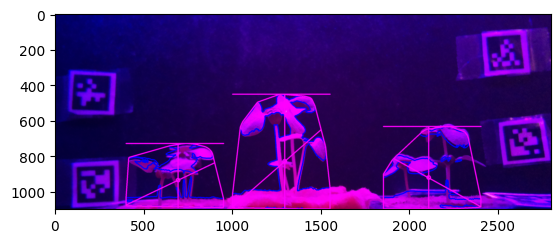

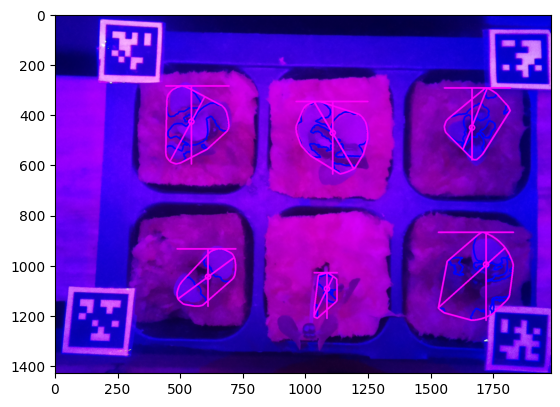

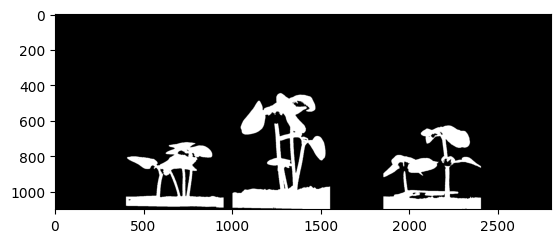

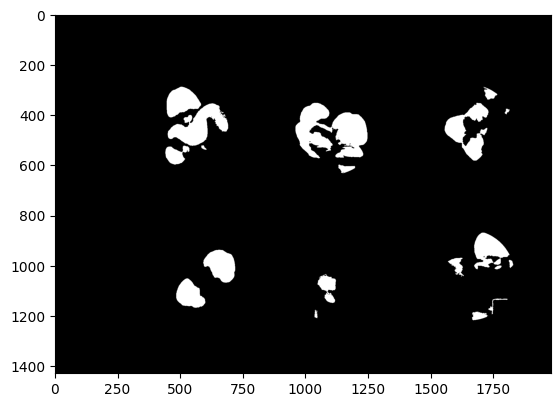

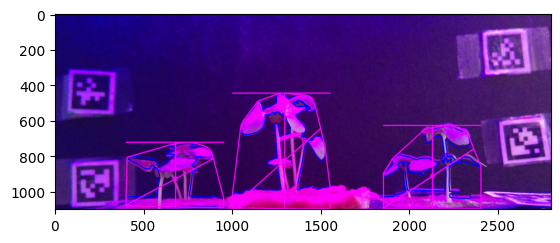

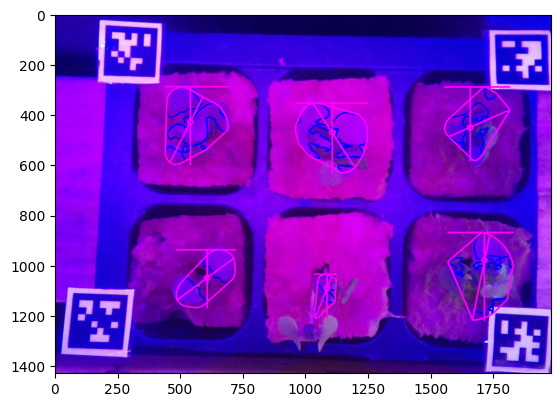

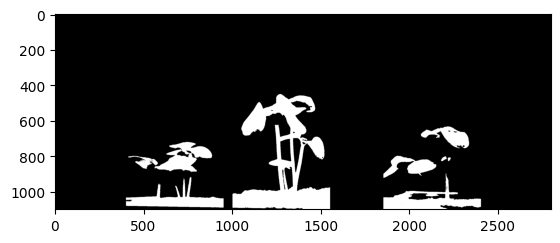

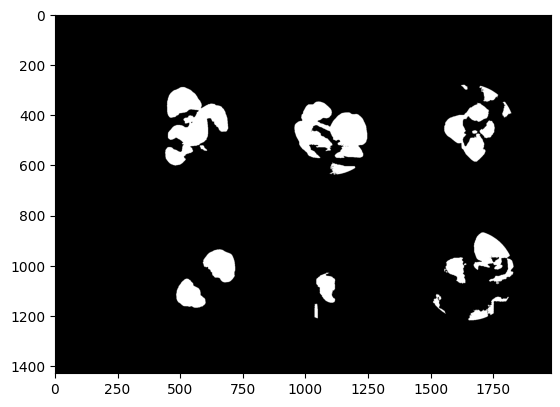

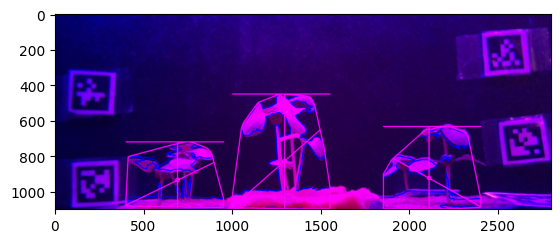

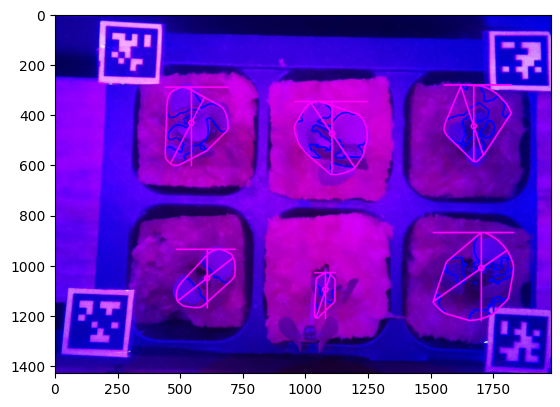

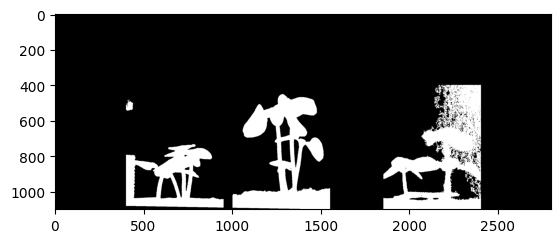

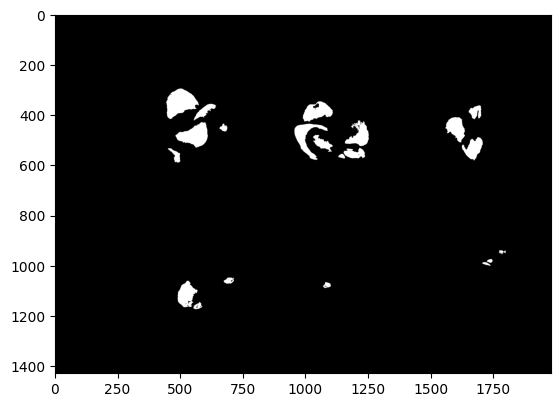

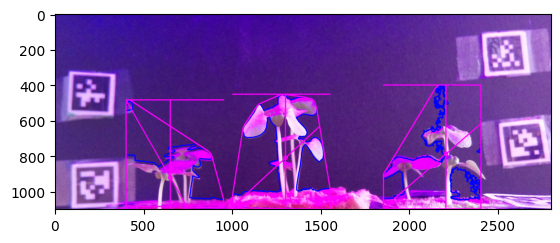

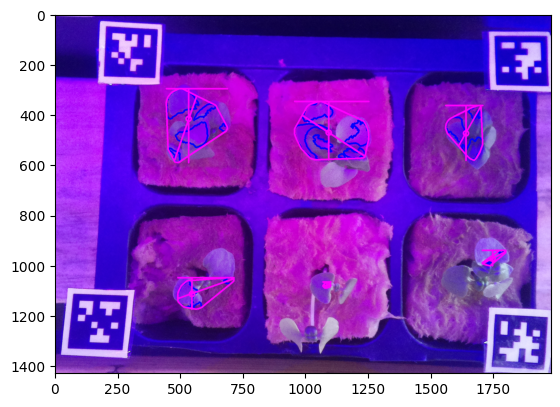

In [35]:
dt_str = ['3/12/2022 10:08:18','3/12/2022 20:08:18','4/12/2022 10:08:18','4/12/2022 20:08:18']

plant1_height = []
plant1_area = []
plant2_height = []
plant2_area = []
plant3_height = []
plant3_area = []
plant4_height = []
plant4_area = []
plant5_height = []
plant5_area = []
plant6_height = []
plant6_area = []

for i in range(0, len(dt_str)):
    side_image, top_image = load_images(dt_str[i])
    side_gray_img = filter_side_image(side_image)
    top_gray_img = filter_top_image(top_image)
    side_mask, side_rois, side_roi_hierarchy= create_side_mask(side_gray_img)
    top_mask, top_rois, top_roi_hierarchy= create_top_mask(top_gray_img)
    pixel_heights, _ = analyze_shape(side_rois, side_roi_hierarchy, side_image, side_mask)
    pixel_heights = expand_pixel_heights(pixel_heights)
    _, pixel_areas = analyze_shape(top_rois, top_roi_hierarchy, top_image, top_mask)
    pixel_areas = reorder_areas_to_match_heights(pixel_areas)
    plant_heights,plant_areas = calculate_plant_size(pixel_heights, pixel_areas)
    plant1_height.append(plant_heights[0])
    plant1_area.append(plant_areas[0])
    plant2_height.append(plant_heights[1])
    plant2_area.append(plant_areas[1])
    plant3_height.append(plant_heights[2])
    plant3_area.append(plant_areas[2])
    plant4_height.append(plant_heights[3])
    plant4_area.append(plant_areas[3])
    plant5_height.append(plant_heights[4])
    plant5_area.append(plant_areas[4])
    plant6_height.append(plant_heights[5])
    plant6_area.append(plant_areas[5])
    
    

In [36]:
print(plant1_height)
print(plant1_area)
print(plant2_height)
print(plant2_area)
print(plant3_height)
print(plant3_area)
print(plant4_height)
print(plant4_area)
print(plant5_height)
print(plant5_area)
print(plant6_height)
print(plant6_area)

[21.96763515998529, 22.392423685178375, 22.51379183523354, 36.89591761677087]
[157.80535133715415, 149.92760343461464, 162.89775731418862, 76.43753123823826]
[16.642147848473705, 16.963957337256343, 17.055902905479957, 27.95145273997793]
[93.77115639034272, 93.27462118918321, 94.83331938013778, 25.78113480287195]
[39.32328061787422, 39.68738506803972, 39.3839646929018, 39.32328061787422]
[142.4849348716327, 132.52690333204123, 148.22218947954946, 77.36413036483874]
[29.790364104450166, 30.066200809121, 29.83633688856197, 29.790364104450166]
[22.689683291757902, 19.518681087173004, 26.347333251459673, 1.8457410760652802]
[28.27877896285399, 28.64288341301949, 28.27877896285399, 42.47885251930857]
[83.41532727950478, 74.95555153547221, 98.55237921015656, 36.56676603462262]
[21.423317396101506, 21.699154100772343, 21.423317396101506, 32.18094887826407]
[95.09138868127921, 72.60023265368255, 115.83075800673126, 2.7504344862372014]
